In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ct
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
/content/drive/MyDrive/ct


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, resize, rotate, AffineTransform, warp
import random

import numpy as np
import matplotlib.pyplot as plt

MNIST phase retrivial

100%|██████████| 9.91M/9.91M [00:00<00:00, 52.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.95MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.93MB/s]


Epoch 1, Loss: 0.082392
Epoch 2, Loss: 0.048535
Epoch 3, Loss: 0.036454
Epoch 4, Loss: 0.030618
Epoch 5, Loss: 0.027273
Epoch 6, Loss: 0.024574
Epoch 7, Loss: 0.022449
Epoch 8, Loss: 0.020902
Epoch 9, Loss: 0.019439
Epoch 10, Loss: 0.018310
Test Loss: 0.020142


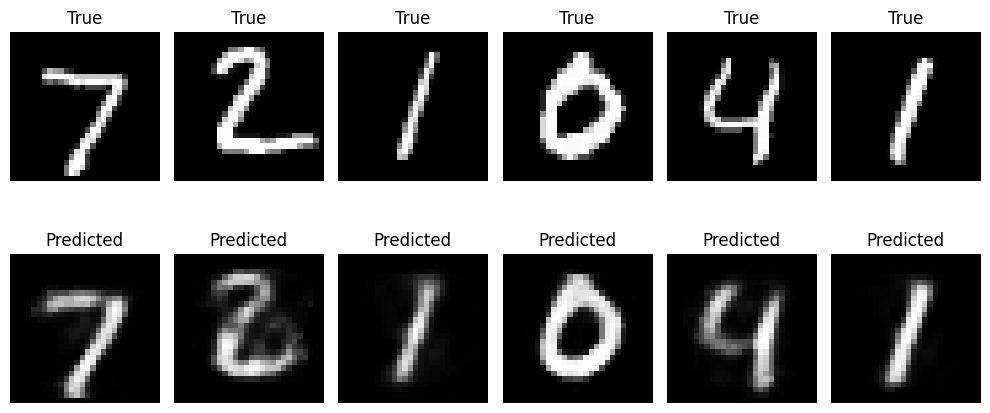

In [4]:
# Load MNIST and preprocess
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to [0,1]
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to vector
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Only keep a small subset for speed
train_dataset.data = train_dataset.data[:5000]
train_dataset.targets = train_dataset.targets[:5000]
test_dataset.data = test_dataset.data[:1000]
test_dataset.targets = test_dataset.targets[:1000]

# Measurement Simulation
def simulate_measurements(x, A):
    # Forward model: y_m = | <a_m, x> |^2
    Ax = torch.matmul(A, x.T)  # (num_measurements, batch_size)
    y = (Ax.abs() ** 2).T       # (batch_size, num_measurements)
    return y

# Parameters
input_dim = 28 * 28  # 784
num_measurements = 200  # M << N

# Random Gaussian sensing matrix A
A = torch.randn(num_measurements, input_dim) / np.sqrt(input_dim)

# Simulate measurements for training and test sets
X_train = train_dataset.data.view(-1, input_dim).float() / 255.0
Y_train = simulate_measurements(X_train, A)

X_test = test_dataset.data.view(-1, input_dim).float() / 255.0
Y_test = simulate_measurements(X_test, A)

# Build PyTorch datasets
train_loader = DataLoader(TensorDataset(Y_train, X_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(Y_test, X_test), batch_size=64, shuffle=False)

# basic Neural Network
class InverseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_measurements, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Since pixel intensities are in [0,1]
        )

    def forward(self, y):
        return self.model(y)

net = InverseNet()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training
for epoch in range(10):
    net.train()
    total_loss = 0
    for y_batch, x_batch in train_loader:
        optimizer.zero_grad()
        x_pred = net(y_batch)
        loss = criterion(x_pred, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.6f}")

# Testing
net.eval()
test_loss = 0
with torch.no_grad():
    for y_batch, x_batch in test_loader:
        x_pred = net(y_batch)
        loss = criterion(x_pred, x_batch)
        test_loss += loss.item()
print(f"Test Loss: {test_loss/len(test_loader):.6f}")

# Visualize some results
import matplotlib.pyplot as plt

y_example, x_true = next(iter(test_loader))
x_pred = net(y_example)

plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,6,i+1)
    plt.imshow(x_true[i].view(28,28), cmap='gray')
    plt.axis('off')
    plt.title("True")

    plt.subplot(2,6,i+7)
    plt.imshow(x_pred[i].view(28,28).detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("Predicted")
plt.tight_layout()
plt.show()

Shepp-Logan Phantom

/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Epoch 1, Loss: 0.039950
Epoch 2, Loss: 0.016565
Epoch 3, Loss: 0.009198
Epoch 4, Loss: 0.006412
Epoch 5, Loss: 0.004922
Epoch 6, Loss: 0.003915
Epoch 7, Loss: 0.003257
Epoch 8, Loss: 0.002786
Epoch 9, Loss: 0.002479
Epoch 10, Loss: 0.002236


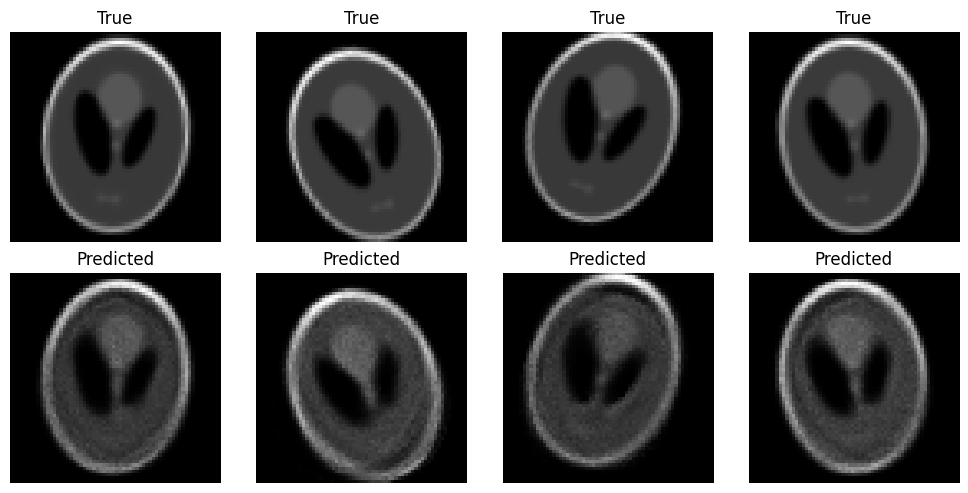

In [2]:
# Step 1: Generate dataset of phantoms
def generate_phantoms(num_samples, size=64):
    images = []
    base_phantom = shepp_logan_phantom()  # always the same base
    base_phantom = resize(base_phantom, (size, size))

    for _ in range(num_samples):
        img = base_phantom.copy()

        # Random rotation (-30 to 30 degrees)
        angle = random.uniform(-30, 30)
        img = rotate(img, angle, mode='edge')

        # Random shift (up to ±5% of image size)
        shift_x = random.uniform(-0.05, 0.05) * size
        shift_y = random.uniform(-0.05, 0.05) * size
        transform = AffineTransform(translation=(shift_x, shift_y))
        img = warp(img, transform, mode='edge')

        # Random intensity scaling (0.9 to 1.1)
        scale = random.uniform(0.9, 1.1)
        img = np.clip(img * scale, 0, 1)

        images.append(img)

    return np.stack(images)

# Parameters
image_size = 64
num_samples_train = 1000
num_samples_test = 200
angles = np.linspace(0., 180., max(image_size//2, 30), endpoint=False)  # CT scan angles

# Generate
X_train = generate_phantoms(num_samples_train, image_size)
X_test  = generate_phantoms(num_samples_test, image_size)

# Step 2: Simulate CT measurements (Radon transform)
def simulate_measurements_CT(images, angles):
    measurements = []
    for img in images:
        sino = radon(img, theta=angles, circle=True)  # sinogram
        sino = np.abs(sino)  # take magnitude
        sino_squared = sino**2
        sino_log = np.log1p(sino_squared)  # log(1+x) to stabilize
        measurements.append(sino_log.flatten())
    return np.stack(measurements)

Y_train = simulate_measurements_CT(X_train, angles)
Y_test = simulate_measurements_CT(X_test, angles)

# Normalize
X_train = torch.tensor(X_train).float().view(-1, image_size*image_size)
X_test = torch.tensor(X_test).float().view(-1, image_size*image_size)
Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()

# Normalize measurements (important!)
Y_train = (Y_train - Y_train.mean()) / Y_train.std()
Y_test = (Y_test - Y_test.mean()) / Y_test.std()

# Step 3: Build DataLoaders
train_loader = DataLoader(TensorDataset(Y_train, X_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(Y_test, X_test), batch_size=32, shuffle=False)

# Step 4: Define Neural Network
class InverseNet(nn.Module):
    def __init__(self, num_measurements, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_measurements, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
            nn.Sigmoid()
        )

    def forward(self, y):
        return self.model(y)

input_dim = len(angles) * image_size  # measurement dimension
output_dim = image_size * image_size

net = InverseNet(input_dim, output_dim)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Step 5: Train the network
for epoch in range(10):
    net.train()
    total_loss = 0
    for y_batch, x_batch in train_loader:
        optimizer.zero_grad()
        x_pred = net(y_batch)
        loss = criterion(x_pred, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.6f}")

# Step 6: Test and Visualize
net.eval()
with torch.no_grad():
    y_batch, x_true_batch = next(iter(test_loader))
    x_pred_batch = net(y_batch)

plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(x_true_batch[i].view(image_size, image_size), cmap='gray')
    plt.axis('off')
    plt.title('True')

    plt.subplot(2,4,i+5)
    plt.imshow(x_pred_batch[i].view(image_size, image_size), cmap='gray')
    plt.axis('off')
    plt.title('Predicted')

plt.tight_layout()
plt.show()

Filtered Backprojection method

(64, 32)


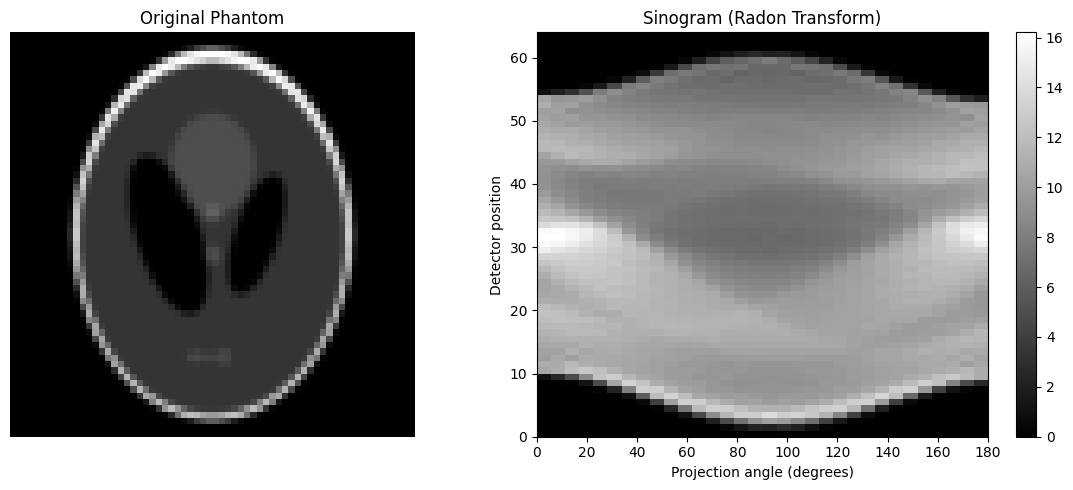

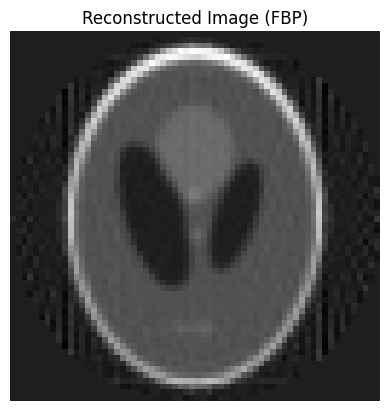

In [6]:
# Pick one sample image from your training set
sample_img = X_train[0].view(64, 64).numpy()  # remember X_train was flattened

# Define the angles you used
angles = np.linspace(0., 180., max(sample_img.shape)//2, endpoint=False)

# Compute its sinogram
sino = radon(sample_img, theta=angles, circle=True)
print(sino.shape)

# Plot
plt.figure(figsize=(12,5))

# Original image
plt.subplot(1,2,1)
plt.imshow(sample_img, cmap='gray')
plt.title('Original Phantom')
plt.axis('off')

# Sinogram
plt.subplot(1,2,2)
plt.imshow(sino, cmap='gray', extent=(0, 180, 0, sino.shape[0]), aspect='auto')
plt.title('Sinogram (Radon Transform)')
plt.xlabel('Projection angle (degrees)')
plt.ylabel('Detector position')
plt.colorbar()
plt.tight_layout()
plt.show()


# Reconstruct the image from the sinogram
reconstruction = iradon(sino, theta=angles, circle=True)

# Plot reconstructed image
plt.imshow(reconstruction, cmap='gray')
plt.title('Reconstructed Image (FBP)')
plt.axis('off')
plt.show()